In [2]:
from warnings import simplefilter
simplefilter("ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

# Import et mise en forme #

In [25]:
df_source = pd.read_csv("sources/3_residus_h_noTrend_noSeason.csv")
df_source.dtypes

Unnamed: 0      int64
Date           object
Résidus_h     float64
dtype: object

In [26]:
df_source.drop(columns=["Unnamed: 0"], inplace=True)

In [27]:
# Conversion de la colonne Date de Str en DateTime
df_source["Date"] = pd.to_datetime(df_source["Date"], utc=True)\
                        .dt.tz_convert('Europe/Paris')

In [28]:
df_source.dtypes

Date         datetime64[ns, Europe/Paris]
Résidus_h                         float64
dtype: object

In [29]:
# Import de la table, base quotidienne
df_source_jour = pd.read_csv("sources/3_residus_noTrend_noSeason.csv")
df_source_jour.drop(columns=["Unnamed: 0"], inplace=True)
df_source_jour["Date"] = pd.to_datetime(df_source_jour["Date"], utc=True)\
                        .dt.tz_convert('Europe/Paris')
df_source_jour.dtypes

Date       datetime64[ns, Europe/Paris]
Résidus                         float64
dtype: object

In [30]:
df_source_jour.isna().sum()

Date       0
Résidus    0
dtype: int64

# Definition des fonctions #

In [75]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(22, 6))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [9]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [50]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 4, nrows * 4 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [11]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

# Visualisation #

In [12]:
df_source.isna().sum()

Date         0
Résidus_h    0
dtype: int64

In [55]:
X = make_lags(df_source.Résidus_h, 28)

In [56]:
X.tail(1)

y_lag_1     y_lag_2     y_lag_3      y_lag_4      y_lag_5  \
88391  1474.232827 -778.321078  181.574273  2022.127095  3600.704442   

           y_lag_6      y_lag_7      y_lag_8      y_lag_9     y_lag_10  ...  \
88391  3909.218303  4124.643389  3657.679635  2934.631374  3278.126861  ...   

         y_lag_19  y_lag_20    y_lag_21     y_lag_22   y_lag_23   y_lag_24  \
88391  680.870394   99.0142  422.182034 -1157.630691  74.973605  1943.8789   

         y_lag_25    y_lag_26   y_lag_27     y_lag_28  
88391  703.927096 -888.066382  199.38852  2290.500024  

[1 rows x 28 columns]

In [69]:
# La période 2014 - 2018 est celle qui contient le plus de pics hivernaux, que l'on cherche à anticipier
perdiode_exploratoire = df_source["Résidus_h"].loc[ (df_source["Date"] >= "2014-05-31") & (df_source["Date"] <= "2018-06-01") ]

In [70]:
_ = plot_lags(perdiode_exploratoire, lags=28, nrows=7)

Une corrélation assez forte est observée jusqu'à -6h.<br/>
Très intéressant, on note que la corrélation remonte à Lag 24h, c'est à dire comparativement au même moment de la journée précédente.<br/>
Ce qui confirme notre observation réalisée sur base quotidienne.

In [57]:
# Une autre manière de l'observer est avec la matrice de corrélation de la table ayant produit les lags

# Jointure entre la table Lags et celle d'origine
# Suppression des lignes vides, induites pas le décalage temporel (ex: lag 17 = 17 première lignes vides)
X = df_source.join(X, how='left')
X.dropna(inplace=True)

In [58]:
# Calcul de la matrice de correlation
corr = X.corr()

In [59]:
corr.style.background_gradient(cmap='Greens', axis=0)

In [60]:
# Observation en daily
# Le nombre de lignes nous permet d'observer cela sur toute la période
df_source_jour.shape[0]

3683

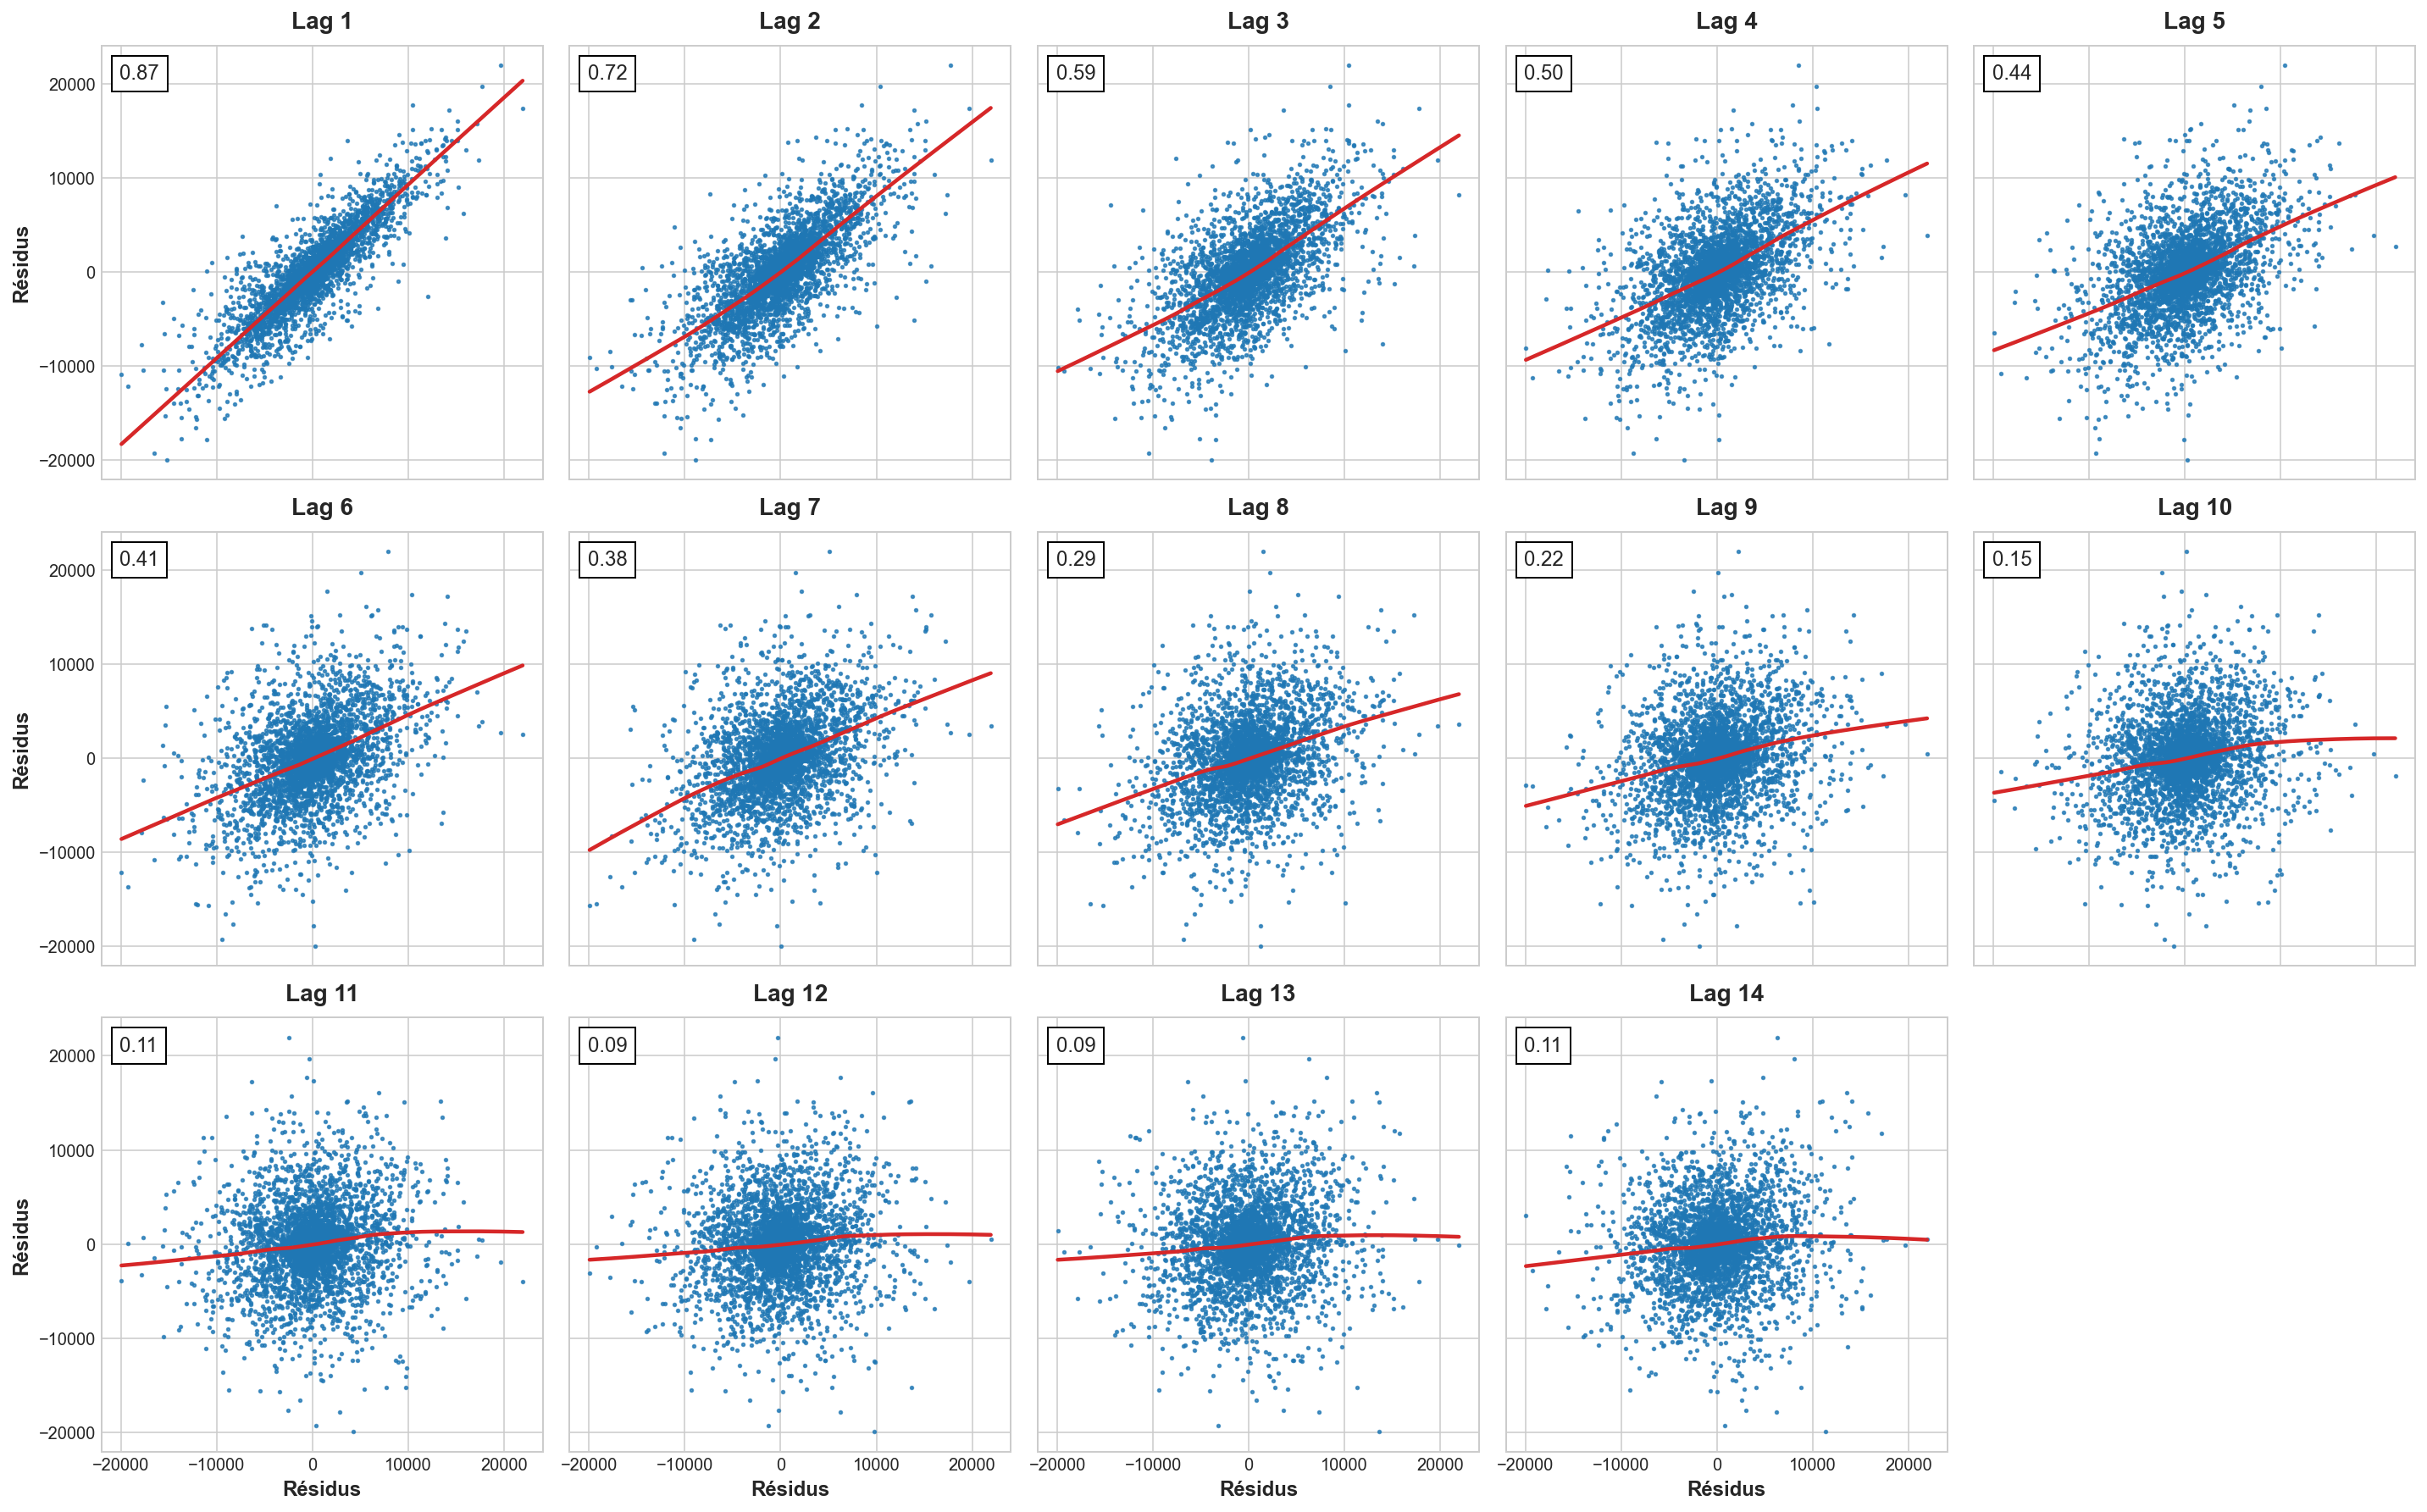

In [61]:
_ = plot_lags(df_source_jour.Résidus, lags=14, nrows=3)

En base quotidienne, on constate une corrélation avec le jour précédent.<br/>
Elle chute assez fortement dès le 2e jour (lag 2), et n'est plus significativement corrélé dès le 3e.

#### Conclusion ####
Les analyses de lags nous renseignent que des cycles pourraient être intégrés à notre modèle en intégrant les features suivantes :
<li> lag -1h à -6h</li>
<li> lag -24h</li>

In [71]:
# Partial autocorrelation
df_source["Résidus_h"]

0         917.734917
1        -801.780772
2         898.136419
3         -70.911168
4        -413.919025
            ...     
88387    2022.127095
88388     181.574273
88389    -778.321078
88390    1474.232827
88391    2771.745936
Name: Résidus_h, Length: 88392, dtype: float64

In [82]:
_ = plot_pacf(df_source["Résidus_h"], lags=30, alpha=.05)

L'auto corrélation partielle nous confirme les résutalts précédents, avec une extension même de ceux-ci :
<li> -1h, -2h et -24h</li>
<li> Mais également désormais (bien que de moindre amplitude) -3h, -23h, -24h, -25h, -26h</li>

# Ajout de Features complémentaires #

### Caractéristiques identifiées dans Saisonnalité, et non prises en compte jusqu'à présent ###
Référence à la saison, et au moment de la journée.<br />
Pour les personnes disposant du Dataset des vacances scolaires de 2012-2022 et par zones, cela pourrait-être également intéressant

In [93]:
# Extraction du mois, jour et heure
df_source.head(1)

Date   Résidus_h
0 2012-05-01 00:00:00+02:00  917.734917

In [94]:
df_source["DayOfYear"] = df_source.Date.dt.day_of_year
df_source["DayOfWeek"] = df_source.Date.dt.day_of_week
df_source["Heure"] = df_source.Date.dt.hour

In [102]:
# Définition des critères de classification
# Par saison :
printemps = range(80,172)
ete = range(172,264)
automne = range(264,355)
# Par jour de la semaine (Attention, le lundi commence à 0)
weekend = range(5,7)
# Par moment de la journée
heures_pleines = range(7,14)
fin_journee = range(17,20)
nuit = range(22,6)

In [114]:
def identification_saison(DoY):
    saison="Nan"

    if DoY in printemps:
        saison = "printemps"
    elif DoY in ete:
        saison="ete"
    elif DoY in automne:
        saison="automne"
    else:
        saison="hiver"
    
    return saison

In [115]:
def identification_WE(DoW):
    jour="Nan"
    
    if DoW in weekend:
        jour="week-end"
    else:
        jour="semaine"
    
    return jour

In [122]:
def moment_journee(H):
    moment=""
    
    if H in heures_pleines:
        moment = "haute_consommation"
    elif H in fin_journee:
        moment="haute_consommation"
    elif H in nuit:
        moment="basse_consommation"
    else:
        moment="consommation_normale"
    
    return moment

In [123]:
df_source["Saison"] = df_source["DayOfYear"].apply(identification_saison)
df_source["Moment_semaine"] = df_source["DayOfWeek"].apply(identification_WE)
df_source["Moment_journee"] = df_source["Heure"].apply(moment_journee)

In [133]:
df_source.tail()

Date    Résidus_h  DayOfYear  DayOfWeek  Heure  \
88387 2022-05-31 19:00:00+02:00  2022.127095        151          1     19   
88388 2022-05-31 20:00:00+02:00   181.574273        151          1     20   
88389 2022-05-31 21:00:00+02:00  -778.321078        151          1     21   
88390 2022-05-31 22:00:00+02:00  1474.232827        151          1     22   
88391 2022-05-31 23:00:00+02:00  2771.745936        151          1     23   

          Saison Moment_semaine        Moment_journee  
88387  printemps        semaine    Haute_consommation  
88388  printemps        semaine  Consommation_normale  
88389  printemps        semaine  Consommation_normale  
88390  printemps        semaine  Consommation_normale  
88391  printemps        semaine  Consommation_normale

In [134]:
df_source.drop(columns=["DayOfYear","DayOfWeek","Heure"], inplace=True)

In [135]:
df_source = pd.get_dummies(df_source, prefix="")

In [136]:
df_source.tail()

Date    Résidus_h  _automne  _ete  _hiver  \
88387 2022-05-31 19:00:00+02:00  2022.127095         0     0       0   
88388 2022-05-31 20:00:00+02:00   181.574273         0     0       0   
88389 2022-05-31 21:00:00+02:00  -778.321078         0     0       0   
88390 2022-05-31 22:00:00+02:00  1474.232827         0     0       0   
88391 2022-05-31 23:00:00+02:00  2771.745936         0     0       0   

       _printemps  _semaine  _week-end  _Consommation_normale  \
88387           1         1          0                      0   
88388           1         1          0                      1   
88389           1         1          0                      1   
88390           1         1          0                      1   
88391           1         1          0                      1   

       _Haute_consommation  
88387                    1  
88388                    0  
88389                    0  
88390                    0  
88391                    0

### Ajout de Features Statistiques ###
Il n'est pas certain qu'elles puissent être véritables utiles. Mais elles ne nuisent pas.<br />
Nous pourrons à l'entraînement des modèles vérifier cela avec Feature importance.

14-day rolling median (median) of lagged target
7-day rolling standard deviation (std) of lagged target

In [140]:
df_features = df_source[["Date","Résidus_h"]].copy()

In [147]:
def make_lags_from_list(df_in, lags_list):
    """Crée des colonnes lag correspondant à chaque élement contenu dans un liste.
    Utile pour générer uniquement les lags qui nous interessent plutôt que tout un range.
    Le prérequis indispensable à l'utilisation de cette fonction est que la dernière colonne soit la cible sur laquelle on applique le lag"""

    for lag in lags_list:
        # 
        df_in["lag_"+str(lag)] = df_in.iloc[:,-1].shift(lag)
    
    return df_in

In [148]:
lags_selectionnes = [1,2,3,23,24,25,26]

In [149]:
df_features = make_lags_from_list(df_features, lags_selectionnes)

In [150]:
df_features.tail()

Date    Résidus_h        lag_1        lag_2  \
88387 2022-05-31 19:00:00+02:00  2022.127095  3600.704442  4124.643389   
88388 2022-05-31 20:00:00+02:00   181.574273  2022.127095  3909.218303   
88389 2022-05-31 21:00:00+02:00  -778.321078   181.574273  3600.704442   
88390 2022-05-31 22:00:00+02:00  1474.232827  -778.321078  2022.127095   
88391 2022-05-31 23:00:00+02:00  2771.745936  1474.232827   181.574273   

             lag_3       lag_23       lag_24       lag_25       lag_26  
88387  3278.126861  2596.784808 -6460.998729 -4055.038683 -2839.788747  
88388  2934.631374  3061.278672 -6053.040287 -5222.140951 -1326.495340  
88389  3657.679635  3252.687182 -5670.167937 -4431.701664 -1340.390213  
88390  4124.643389  3421.706000 -4761.686021 -3944.349092 -2329.997648  
88391  3909.218303  3441.635185 -5096.294484 -3576.387581 -1977.064030

In [154]:
# Agrégation définitive des Features générées dans un même dataset
# Pour éviter d'avoir deux colonnes cibles, on fait la jointure en supprimant Résidus_h sur l'une des deux tables
df_to_train = df_features.merge(df_source.drop(columns=["Résidus_h"]), how="left", on="Date")

In [156]:
# Suppression des lignes vides, à cause du lag.
# Dans notre cas les 26 premières
df_to_train.dropna(inplace=True)

In [157]:
df_to_train

Date    Résidus_h        lag_1        lag_2  \
104   2012-05-05 08:00:00+02:00 -4398.573449 -4061.466868  -330.661254   
105   2012-05-05 09:00:00+02:00 -3328.875044 -4398.573449 -1776.934292   
106   2012-05-05 10:00:00+02:00 -3340.759972 -3328.875044 -4061.466868   
107   2012-05-05 11:00:00+02:00 -3367.825077 -3340.759972 -4398.573449   
108   2012-05-05 12:00:00+02:00 -2516.686752 -3367.825077 -3328.875044   
...                         ...          ...          ...          ...   
88387 2022-05-31 19:00:00+02:00  2022.127095  3600.704442  4124.643389   
88388 2022-05-31 20:00:00+02:00   181.574273  2022.127095  3909.218303   
88389 2022-05-31 21:00:00+02:00  -778.321078   181.574273  3600.704442   
88390 2022-05-31 22:00:00+02:00  1474.232827  -778.321078  2022.127095   
88391 2022-05-31 23:00:00+02:00  2771.745936  1474.232827   181.574273   

             lag_3       lag_23       lag_24       lag_25       lag_26  \
104     892.686729   922.297909  2563.902713 -1194.249409   917.734917   
105      24.158799   981.966835  2272.705834 -1595.377502  -801.780772   
106    -406.333833  2950.802123  4194.676445 -1200.466921   898.136419   
107    -330.661254  4379.692946  5981.703722  2020.612249   -70.911168   
108   -1776.934292  5481.325382  7134.473742  4408.749184  -413.919025   
...            ...          ...          ...          ...          ...   
88387  3278.126861  2596.784808 -6460.998729 -4055.038683 -2839.788747   
88388  2934.631374  3061.278672 -6053.040287 -5222.140951 -1326.495340   
88389  3657.679635  3252.687182 -5670.167937 -4431.701664 -1340.390213   
88390  4124.643389  3421.706000 -4761.686021 -3944.349092 -2329.997648   
88391  3909.218303  3441.635185 -5096.294484 -3576.387581 -1977.064030   

       _automne  _ete  _hiver  _printemps  _semaine  _week-end  \
104           0     0       0           1         0          1   
105           0     0       0           1         0          1   
106           0     0       0           1         0          1   
107           0     0       0           1         0          1   
108           0     0       0           1         0          1   
...         ...   ...     ...         ...       ...        ...   
88387         0     0       0           1         1          0   
88388         0     0       0           1         1          0   
88389         0     0       0           1         1          0   
88390         0     0       0           1         1          0   
88391         0     0       0           1         1          0   

       _Consommation_normale  _Haute_consommation  
104                        0                    1  
105                        0                    1  
106                        0                    1  
107                        0                    1  
108                        0                    1  
...                      ...                  ...  
88387                      0                    1  
88388                      1                    0  
88389                      1                    0  
88390                      1                    0  
88391                      1                    0  

[88288 rows x 17 columns]

In [159]:
df_to_train.to_csv("sources/4_residus_enrichis_pour_entrainement", header=True)